# Analysis


In [44]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt

In [45]:
calc_df=pd.read_csv('../outputs/calc_dataset.csv', low_memory=False)
calc_df=calc_df.drop(['Unnamed: 0',], axis=1)
calc_df.head()

,name,long,lat,df_name,cat1,cat2,cat1_name,cat2_name,10001708,10001709,...,51039101,51039401,51039402,51039403,51039404,51039405,51039406,51039407,51039408,51039410
0,FORZE ARMATE,9.107364,45.456290,acqua,NaN,NaN,NaN,NaN,7540.1,7540.1,...,4609.7,8467.6,8467.6,8467.6,8467.6,8467.6,8467.6,8467.6,8467.6,8467.6
1,LORENTEGGIO,9.125151,45.458188,acqua,NaN,NaN,NaN,NaN,6445.5,6445.5,...,3735.9,7593.8,7593.8,7593.8,7593.8,7593.8,7593.8,7593.8,7593.8,7593.8
2,BANDE NERE,9.136149,45.461792,acqua,NaN,NaN,NaN,NaN,5797.8,5797.8,...,3165.9,7023.8,7023.8,7023.8,7023.8,7023.8,7023.8,7023.8,7023.8,7023.8
3,GIAMBELLINO,9.153322,45.452348,acqua,NaN,NaN,NaN,NaN,4673.6,4673.6,...,3846.8,7651.5,7651.5,7651.5,7651.5,7651.5,7651.5,7651.5,7651.5,7651.5
4,GRATOSOGLIO - Q.RE MISSAGLIA - Q.RE TERRAZZE,9.171006,45.408128,acqua,NaN,NaN,NaN,NaN,5655.9,5655.9,...,8094.3,10803.3,10803.3,10803.3,10803.3,10803.3,10803.3,10803.3,10803.3,10803.3


In [48]:
distr_df=pd.read_csv('../outputs/fixed_dataset.csv', low_memory=False)
distr_df=distr_df.drop(['Unnamed: 0',], axis=1)
distr_df

,name,long,lat,df_name,cat1,cat2,cat1_name,cat2_name,10001708,10001709,...,51039101,51039401,51039402,51039403,51039404,51039405,51039406,51039407,51039408,51039410
0,NaN,9.215730,45.490859,distr,non alimentare,NaN,settore_merceologico,NaN,3715.7,3715.7,...,5219.2,5117.1,5117.1,5117.1,5117.1,5117.1,5117.1,5117.1,5117.1,5117.1
1,NaN,9.192669,45.475107,distr,non alimentare,NaN,settore_merceologico,NaN,3227.0,3227.0,...,3868.7,5256.0,5256.0,5256.0,5256.0,5256.0,5256.0,5256.0,5256.0,5256.0
2,verzeri,NaN,NaN,distr,non alimentare,NaN,settore_merceologico,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,9.174148,45.481307,distr,alimentare|non alimentare,NaN,settore_merceologico,NaN,4480.2,4480.2,...,2663.2,4789.7,4789.7,4789.7,4789.7,4789.7,4789.7,4789.7,4789.7,4789.7
4,riparaz. contachilometri,9.166031,45.481957,distr,non alimentare,NaN,settore_merceologico,NaN,4809.1,4809.1,...,2140.9,5045.4,5045.4,5045.4,5045.4,5045.4,5045.4,5045.4,5045.4,5045.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,NaN,NaN,NaN,distr,NaN,NaN,settore_merceologico,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1023,la rinascente s.p.a.,9.191865,45.465372,distr,Alimentare|Non Alimentare,NaN,settore_merceologico,NaN,2627.3,2627.3,...,4258.5,5986.6,5986.6,5986.6,5986.6,5986.6,5986.6,5986.6,5986.6,5986.6
1024,NaN,NaN,NaN,distr,NaN,NaN,settore_merceologico,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1025,NaN,NaN,NaN,distr,alimentare|non alimentare,NaN,settore_merceologico,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
#replacing distr_df as they were not correctly geocoded
calc_df_fixed = calc_df.drop(calc_df[calc_df.df_name=='distr'].index)
calc_df_fixed = pd.concat([calc_df_fixed, distr_df])
print('Fixed and original dataset have same lenght?', len(calc_df_fixed)==len(calc_df))
if len(calc_df_fixed)==len(calc_df):
    calc_df_fixed.to_csv('../outputs/calc_fixed_df.csv', index=False)

Fixed and original dataset have same lenght? True


## Summary statistics

In [50]:
calc_df_fixed = calc_df_fixed.drop(calc_df_fixed[calc_df_fixed['long'].isna()].index)


In [51]:
desc_mm=calc_df_fixed.groupby('df_name').describe()
desc_mm=desc_mm.drop(['long', 'lat'], axis=1)
desc_mm=desc_mm.T
desc_mm.head()

df_name               acqua       biblio    ciclabili        consu  \
10001708 count    47.000000    22.000000  3551.000000    21.000000   
         mean   4892.323404  4693.854545  4723.407632  3401.933333   
         std    2190.674197  2374.526589  2020.144841  1740.142727   
         min     300.000000   732.400000   167.700000  1149.100000   
         25%    3064.550000  2708.450000  3256.200000  2033.500000   

df_name                cult        distr      edicole     farmacie  \
10001708 count    75.000000   847.000000   562.000000   414.000000   
         mean   3293.048000  3922.098229  4272.305160  4305.478261   
         std     978.047843  1758.667532  1940.521378  2024.596546   
         min    1743.900000   578.900000   342.800000   233.000000   
         25%    2801.900000  2658.950000  2807.500000  2879.775000   

df_name               metro       parchi  ...         serd         sinf  \
10001708 count   110.000000  1065.000000  ...    15.000000   263.000000   
         mean   5610.150909  4802.970047  ...  4445.560000  4764.759696   
         std    3056.697970  2108.603931  ...  1921.965073  2176.150858   
         min    1174.400000   172.600000  ...  2578.400000   201.800000   
         25%    3591.875000  3716.500000  ...  3333.200000  3084.600000   

df_name                sita        sport        sprim          ss2  \
10001708 count   114.000000  1041.000000  1718.000000   174.000000   
         mean   4274.764035  5144.240346  4792.983818  4073.697701   
         std    2024.712556  2223.316616  2151.748558  1787.300165   
         min     455.300000   168.200000   302.400000   819.000000   
         25%    2918.900000  3472.400000  3121.600000  2981.025000   

df_name                ssec        treni          uni         wifi  
10001708 count  1128.000000    24.000000   711.000000   596.000000  
         mean   4544.281294  4543.304167  3615.077637  4699.220638  
         std    2058.149003  2247.137897  1642.314869  2046.524959  
         min     302.400000   879.500000   906.800000   204.500000  
         25%    2922.825000  3174.725000  2450.500000  3049.850000  

[5 rows x 21 columns]

In [52]:
min_services=calc_df_fixed.groupby('df_name').min()
min_services=min_services.drop(['long', 'lat', 'cat1_name', 'cat2_name'], axis=1)
desc_services=pd.DataFrame()
desc_services['min']=min_services.min(axis=1)
desc_services['id_min']=min_services.idxmin(axis=1)
max_services=calc_df_fixed.groupby('df_name').min()
max_services=max_services.drop(['long', 'lat', 'cat1_name', 'cat2_name'], axis=1)
desc_services['max']=max_services.max(axis=1)
desc_services['id_max']=max_services.idxmax(axis=1)
avg_services=calc_df_fixed.groupby('df_name').mean()
desc_services['avg']=avg_services.mean(axis=1)
sd_services=calc_df_fixed.groupby('df_name').std()
desc_services['sd']=avg_services.std(axis=1)
desc_services

C:\Users\iodio\AppData\Local\Temp\ipykernel_6240\2763110821.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  min_services=calc_df_fixed.groupby('df_name').min()
C:\Users\iodio\AppData\Local\Temp\ipykernel_6240\2763110821.py:6: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  max_services=calc_df_fixed.groupby('df_name').min()
C:\Users\iodio\AppData\Local\Temp\ipykernel_6240\2763110821.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_services=calc_df_fixed.groupby('

,min,id_min,max,id_max,avg,sd
df_name,,,,,,
acqua,42.9,51038202,13984.1,10004632,6054.279840,2347.430018
biblio,25.2,41021101,15024.7,10004632,5606.063862,2438.637468
ciclabili,7.7,51023704,12537.1,10004632,5770.454759,2421.715487
consu,18.8,30001601,16405.1,10004632,5364.003629,2481.104408
cult,52.8,20000804,15840.1,10004632,4859.519565,2536.023484
distr,31.7,51010801,13909.9,10004632,5344.889841,2459.737776
edicole,6.0,10001902,13663.2,10004632,5534.591833,2428.477730
farmacie,0.0,30003501,13321.0,10004632,5556.572903,2422.580220
metro,33.8,10003802,12504.2,10004632,6680.246512,2349.028751


In [53]:
max_20=calc_df_fixed.groupby('df_name').min()
max_20=max_20.drop(['long', 'lat', 'cat1_name', 'cat2_name'], axis=1)
max_20=max_20.T
max_20

C:\Users\iodio\AppData\Local\Temp\ipykernel_6240\4154215261.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  max_20=calc_df_fixed.groupby('df_name').min()


df_name,acqua,biblio,ciclabili,consu,cult,distr,edicole,farmacie,metro,parchi,...,serd,sinf,sita,sport,sprim,ss2,ssec,treni,uni,wifi
10001708,300.0,732.4,167.7,1149.1,1743.9,578.9,342.8,233.0,1174.4,172.6,...,2578.4,201.8,455.3,168.2,302.4,819.0,302.4,879.5,906.8,204.5
10001709,300.0,732.4,167.7,1149.1,1743.9,578.9,342.8,233.0,1174.4,172.6,...,2578.4,201.8,455.3,168.2,302.4,819.0,302.4,879.5,906.8,204.5
10001710,300.0,732.4,167.7,1149.1,1743.9,578.9,342.8,233.0,1174.4,172.6,...,2578.4,201.8,455.3,168.2,302.4,819.0,302.4,879.5,906.8,204.5
10001711,300.0,732.4,167.7,1149.1,1743.9,578.9,342.8,233.0,1174.4,172.6,...,2578.4,201.8,455.3,168.2,302.4,819.0,302.4,879.5,906.8,204.5
10001712,300.0,732.4,167.7,1149.1,1743.9,578.9,342.8,233.0,1174.4,172.6,...,2578.4,201.8,455.3,168.2,302.4,819.0,302.4,879.5,906.8,204.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51039405,832.8,952.8,372.5,644.2,4377.2,837.7,514.8,756.2,532.6,1489.9,...,2969.7,350.9,564.3,745.3,425.6,1077.7,717.5,557.6,2607.6,573.5
51039406,832.8,952.8,372.5,644.2,4377.2,837.7,514.8,756.2,532.6,1489.9,...,2969.7,350.9,564.3,745.3,425.6,1077.7,717.5,557.6,2607.6,573.5
51039407,832.8,952.8,372.5,644.2,4377.2,837.7,514.8,756.2,532.6,1489.9,...,2969.7,350.9,564.3,745.3,425.6,1077.7,717.5,557.6,2607.6,573.5
51039408,832.8,952.8,372.5,644.2,4377.2,837.7,514.8,756.2,532.6,1489.9,...,2969.7,350.9,564.3,745.3,425.6,1077.7,717.5,557.6,2607.6,573.5


(array([798.,  55.,  25.,   5.,   3.,   4.,  26.,  11.,   2.,   2.]),
 array([   17.5 ,  1528.69,  3039.88,  4551.07,  6062.26,  7573.45,
         9084.64, 10595.83, 12107.02, 13618.21, 15129.4 ]),
 <BarContainer object of 10 artists>)

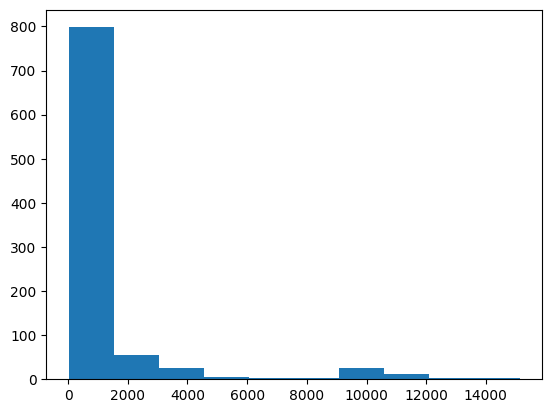

In [54]:
plt.hist(max_20['ss2'])